In [1]:
install.packages("BiocManager")
library(BiocManager)
BiocManager::install("DESeq2")
BiocManager::install("vsn")
BiocManager::install("NMF")
BiocManager::install("EnsDb.Mmusculus.v75")
library(EnsDb.Mmusculus.v75)
library(DESeq2)
library(vsn)
library(NMF)
library(magrittr) #this will allow us to string commands together in a UNIX-pipe-like fashion using %>%
library(ggplot2)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Bioconductor version 3.9 (BiocManager 1.30.9), ?BiocManager::install for help
Bioconductor version 3.9 (BiocManager 1.30.9), R 3.6.1 (2019-07-05)
Installing package(s) 'DESeq2'
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'askpass', 'backports', 'boot', 'callr', 'caret', 'clipr',
  'cluster', 'curl', 'data.table', 'dbplyr', 'digest', 'dplyr', 'evaluate',
  'foreach', 'foreign', 'formatR', 'fs', 'ggplot2', 'glmnet', 'gower', 'haven',
  'hexbin', 'hms', 'htmltools', 'htmlwidgets', 'httpuv', 'httr', 'ipred',
  'IRkernel', 'iterators', 'KernSmooth', 'knitr', 'later', 'lava', 'markdown',
  'MASS', 'mgcv', 'mime', 'modelr', 'nlme', 'numDeriv', 'openssl', 'pillar',
  'pkgconfig', 'processx', 'progress', 'promises', 'purrr', 'quantmod', 'Rcpp',
  'recipes', 'repr', 'reprex', 'rmarkdown', 'rvest', 'shiny', 'sys', 'tibble',
  'tidyr', 'tinytex', 'TTR', 'whisker', 'xfun', '

In [131]:
# get the table of read counts by indicating the path to the file
readcounts <-read.table ("./raw_countstdl.tsv", header = TRUE)
head(readcounts)
str(readcounts)

,ctl1,ctl2,ctl3,ctl4,treat1,treat2,treat3,treat4
ENSMUSG00000102693,0,0,0,0,0,0,0,0
ENSMUSG00000064842,0,0,0,0,1,0,0,0
ENSMUSG00000051951,2,0,1,1,11,2,1,24
ENSMUSG00000102851,0,0,0,0,0,0,0,0
ENSMUSG00000103377,0,0,0,0,0,0,0,0
ENSMUSG00000104017,0,0,0,0,0,0,0,0


'data.frame':	45706 obs. of  8 variables:
 $ ctl1  : int  0 0 2 0 0 0 0 0 0 0 ...
 $ ctl2  : int  0 0 0 0 0 0 0 0 0 1 ...
 $ ctl3  : int  0 0 1 0 0 0 0 0 0 0 ...
 $ ctl4  : int  0 0 1 0 0 0 0 0 0 0 ...
 $ treat1: int  0 1 11 0 0 0 0 0 0 0 ...
 $ treat2: int  0 0 2 0 0 0 0 0 0 0 ...
 $ treat3: int  0 0 1 0 0 0 0 0 0 0 ...
 $ treat4: int  0 0 24 0 0 0 0 0 0 0 ...


In [132]:
 # make a data.frame with meta-data where row.names should match the individual sample names
 sample_info <- data.frame(condition = gsub ( "[1-4]+" , "" , names(readcounts)), row.names = names(readcounts))
 sample_info

,condition
ctl1,ctl
ctl2,ctl
ctl3,ctl
ctl4,ctl
treat1,treat
treat2,treat
treat3,treat
treat4,treat


In [133]:
# generate the DESeqDataSet
DESeq.ds <- DESeqDataSetFromMatrix(countData = readcounts, colData = sample_info, design = ~condition )

# check the result:
colData(DESeq.ds) %>% head
assay(DESeq.ds, "counts") %>% head
rowData(DESeq.ds) %>% head

DataFrame with 6 rows and 1 column
       condition
        <factor>
ctl1         ctl
ctl2         ctl
ctl3         ctl
ctl4         ctl
treat1     treat
treat2     treat

,ctl1,ctl2,ctl3,ctl4,treat1,treat2,treat3,treat4
ENSMUSG00000102693,0,0,0,0,0,0,0,0
ENSMUSG00000064842,0,0,0,0,1,0,0,0
ENSMUSG00000051951,2,0,1,1,11,2,1,24
ENSMUSG00000102851,0,0,0,0,0,0,0,0
ENSMUSG00000103377,0,0,0,0,0,0,0,0
ENSMUSG00000104017,0,0,0,0,0,0,0,0


DataFrame with 6 rows and 0 columns

In [134]:
# test what counts() returns
counts(DESeq.ds) %>% str

# remove genes without any counts
DESeq.ds <- DESeq.ds [rowSums(counts(DESeq.ds)) > 0, ]

# investigate different library sizes
colSums(counts(DESeq.ds)) == colSums(readcounts) # should be the same as colSums ( readcounts )

 int [1:45706, 1:8] 0 0 2 0 0 0 0 0 0 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:45706] "ENSMUSG00000102693" "ENSMUSG00000064842" "ENSMUSG00000051951" "ENSMUSG00000102851" ...
  ..$ : chr [1:8] "ctl1" "ctl2" "ctl3" "ctl4" ...


ctl1   ctl2   ctl3   ctl4 treat1 treat2 treat3 treat4 
  TRUE   TRUE   TRUE   TRUE   TRUE   TRUE   TRUE   TRUE

In [136]:
#DESeq2’s default method to normalize read counts to account for differences in sequencing depths is imple-
#mented in estimateSizeFactors()
#1. for every gene (= row), determine the geometric mean of its read counts across all samples (yielding
#the ”pseudo-reference”, i.e. one value per gene);
#2. divide every value of the count matrix by the corresponding pseudo-reference value;
#3. for every sample (= column), determine the median of these ratios. This is the size factor.

# calculate the size factor and add it to the data set
DESeq.ds <- estimateSizeFactors(DESeq.ds)
sizeFactors(DESeq.ds)

# if you check colData () again , you see that this now contains the sizeFactors
colData(DESeq.ds)

# counts () allows you to immediately retrieve the _ normalized _ read counts
counts.sf_normalized <- counts(DESeq.ds, normalized = TRUE)

ctl1      ctl2      ctl3      ctl4    treat1    treat2    treat3    treat4 
0.8613852 0.7601755 0.8089857 0.8337696 0.9487156 0.8192834 0.9787590 4.0539751

DataFrame with 8 rows and 2 columns
       condition        sizeFactor
        <factor>         <numeric>
ctl1         ctl 0.861385212241083
ctl2         ctl 0.760175549092362
ctl3         ctl 0.808985675298092
ctl4         ctl 0.833769556412077
treat1     treat  0.94871557100813
treat2     treat 0.819283353107582
treat3     treat 0.978758960142215
treat4     treat  4.05397505356715

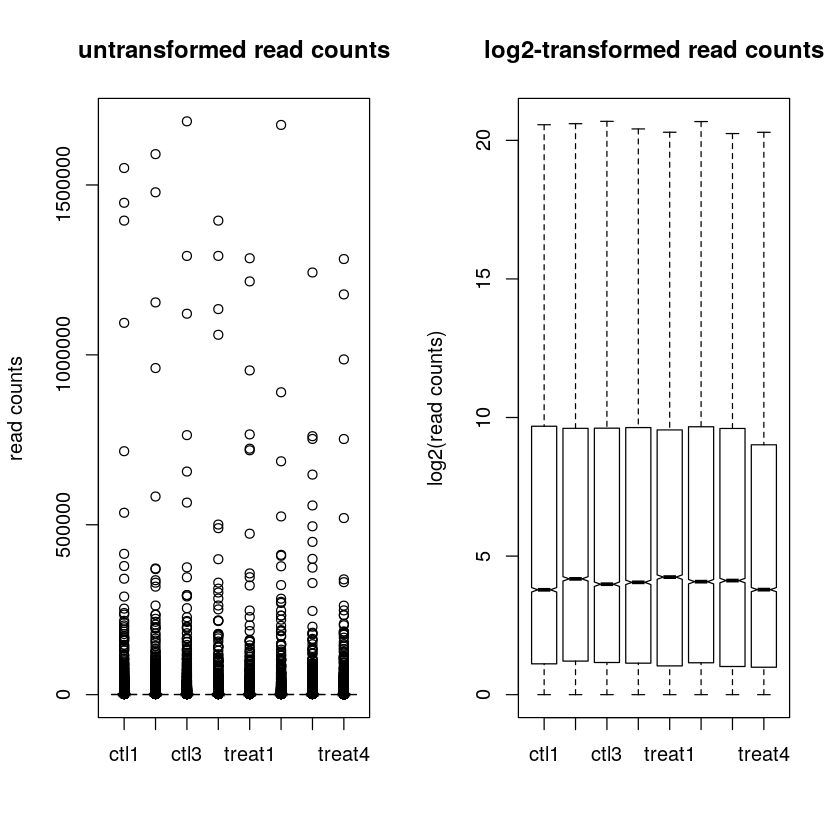

In [137]:
#5.2
#Transformation of sequencing-depth-normalized read counts
#Due to the relatively large dynamic range of expression values that RNA-seq data can cover, many down-
#stream analyses (including clustering) work much better if the read counts are transformed to the log scale
#following normalization. While you will occasionally see log10 transformed read counts, log2 is more com-
#monly used because it is easier to think about doubled values rather than powers of 10. The transformation
#should be done in addition to sequencing depth normalization.

# transform size-factor normalized read counts to log2 scale using pseudocount of 1
log.norm.counts <- log2(counts.sf_normalized + 1)

# plot the following two images underneath each other
par(mfrow = c(1,2))

# boxplots of non-transformed read counts ( one per sample )
boxplot(counts.sf_normalized, notch = TRUE , main = "untransformed read counts" , ylab = "read counts")

# box plots of log2 - transformed read counts
boxplot(log.norm.counts, notch = TRUE , main = "log2-transformed read counts" , ylab = "log2(read counts)")

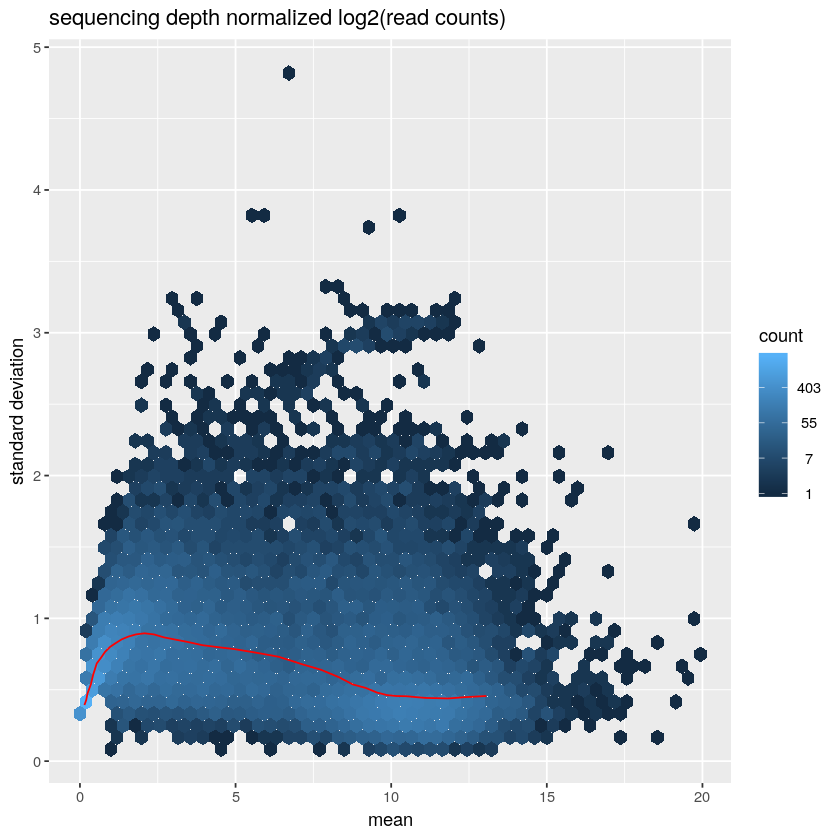

In [138]:
#Many statistical tests and analyses assume that data is homoskedastic, i.e. that all variables have similar
#variance. However, data with large differences among the sizes of the individual observations often shows
#heteroskedastic behavior. One way to visually check for heteroskedasticity is to plot the mean vs. the standard
#deviation.

#mean-sd plot
msd_plot <- meanSdPlot(log.norm.counts, ranks = FALSE, plot = FALSE )
msd_plot$gg +
    ggtitle("sequencing depth normalized log2(read counts)") +
    ylab("standard deviation")

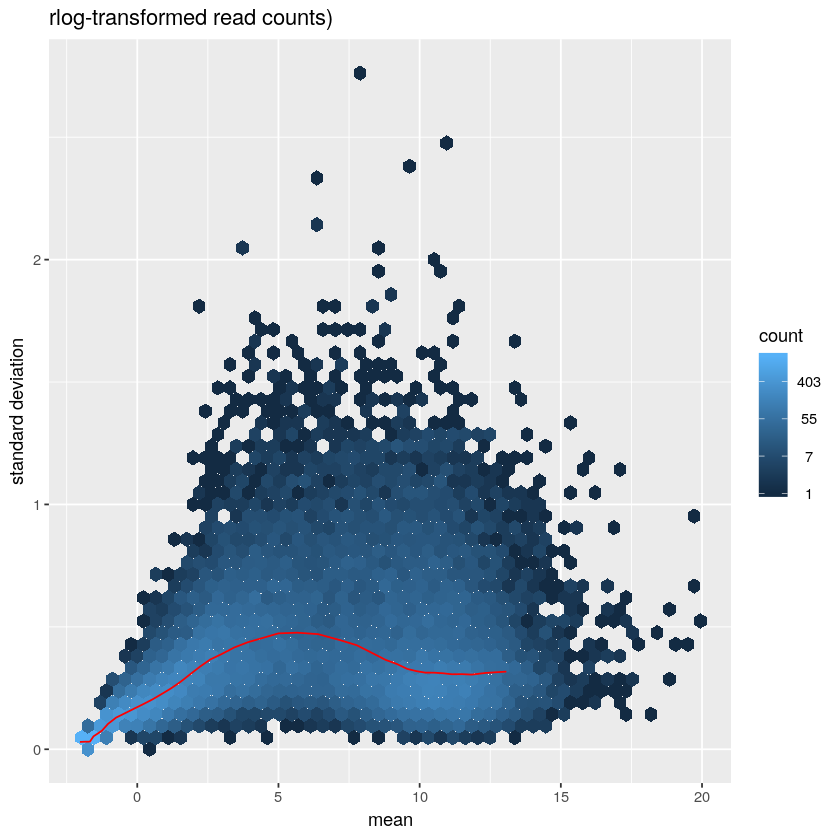

In [139]:
#Transformation of read counts including variance shrinkage
#To reduce the amount of heteroskedasticity, DESeq2 and also edgeR offer several means to shrink the variance
#of low read counts. They do this by using the dispersion-mean trend that can be observed for the entire
#data set as a reference. Consequently, genes with low and highly variable read counts will be assigned more
#homogeneous read count estimates so that their variance resembles the variance observed for the majority
#of the genes (which hopefully have a more stable variance).

  # obtain regularized log - transformed values

#The rlog() function’s blind parameter should be set to FALSE if the different conditions lead to strong differences in a large proportion of the genes. 
DESeq.rlog <- rlog(DESeq.ds, blind = FALSE)
rlog.norm.counts <- assay(DESeq.rlog)

#mean - sd plot for rlog - transformed data
msd_plot <- meanSdPlot(rlog.norm.counts, ranks = FALSE, plot = FALSE)
msd_plot$gg +
    ggtitle("rlog-transformed read counts") +
    ylab("standard deviation")

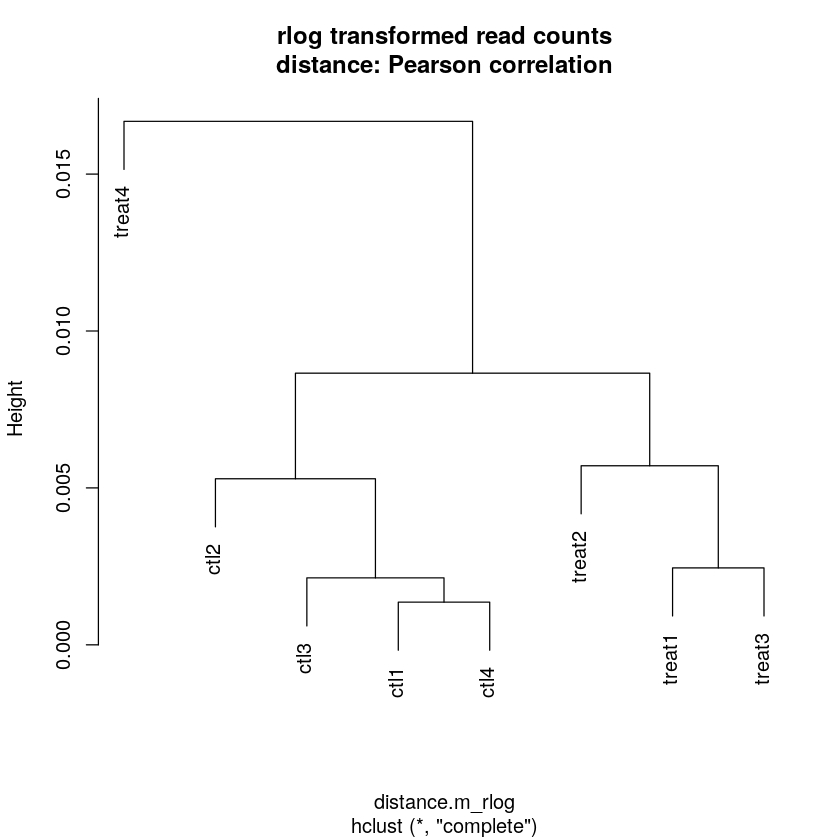

In [140]:
#A dendrogram can be generated in R using the functions cor(), as.dist(), and hclust():

# cor () calculates the correlation between columns of a matrix
distance.m_rlog <- as.dist(1 - cor(rlog.norm.counts , method = "pearson"))

# plot () can directly interpret the output of hclust ()
plot(hclust(distance.m_rlog),
    labels = colnames(rlog.norm.counts) ,
    main = "rlog transformed read counts\ndistance: Pearson correlation")

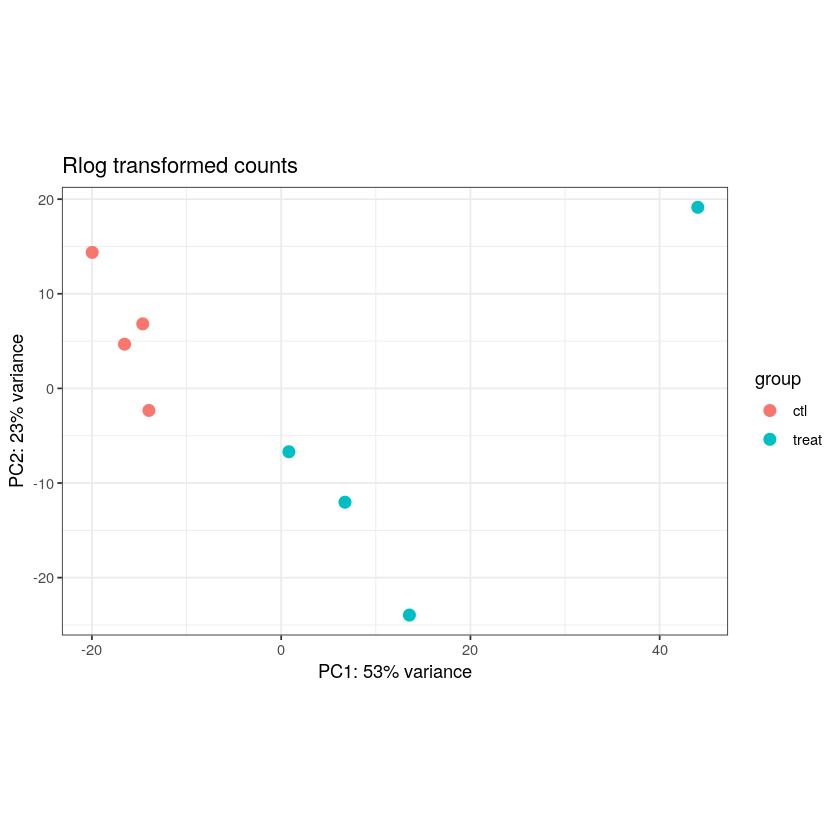

In [141]:
#DESeq2 also offers a convenience function based on ggplot2 to do PCA directly on a DESeqDataSet:

 # PCA
P <- plotPCA (DESeq.rlog)
 # plot cosmetics
P <- P + theme_bw() + ggtitle("Rlog transformed counts")
print(P)

## 2.DGE Analysis

Compare the effect of the treatment (treat) versus the control(ctl) samples, with the control values used as the denominator for the fold change calculation.



In [191]:
# DESeq2 uses the levels of the condition to determine the order of the comparison
str(colData(DESeq.ds)$condition )

    # set ctl as the first-level-factor
colData(DESeq.ds)$condition <- relevel(colData(DESeq.ds)$condition, "ctl")

# run DGE analysis
DESeq.ds <- DESeq(DESeq.ds)

 Factor w/ 2 levels "ctl","treat": 1 1 1 1 2 2 2 2


using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [192]:
DGE.results <- results(DESeq.ds, independentFiltering = TRUE, alpha = 0.05)
summary (DGE.results)

#the DESeqResult object can basically be handled like a data . frame
 head(DGE.results)
 table(DGE.results$padj < 0.05)
 rownames(subset(DGE.results, padj < 0.05))


out of 28474 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 946, 3.3%
LFC < 0 (down)     : 424, 1.5%
outliers [1]       : 15, 0.053%
low counts [2]     : 7729, 27%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



log2 fold change (MLE): condition treat vs ctl 
Wald test p-value: condition treat vs ctl 
DataFrame with 6 rows and 6 columns
                            baseMean    log2FoldChange            lfcSE
                           <numeric>         <numeric>        <numeric>
ENSMUSG00000064842 0.131757086970937 0.269447026812742 3.51215336551651
ENSMUSG00000051951   3.2168660587299  2.12826823090679 1.13577774630742
ENSMUSG00000103147 0.164435701923389 -1.37687865992995 3.52860211417264
ENSMUSG00000103161 0.131757086970937 0.269447026812742 3.51215336551651
ENSMUSG00000102331 0.220214554211007  1.09401434613645  3.4603651328014
ENSMUSG00000102948 0.594666196941426 -3.07937862883515 2.17278686430102
                                 stat             pvalue              padj
                            <numeric>          <numeric>         <numeric>
ENSMUSG00000064842 0.0767184683500051  0.938847512221779                NA
ENSMUSG00000051951   1.87384216483032 0.0609521828593668 0.3130670839134


FALSE  TRUE 
19360  1370 

[1] "ENSMUSG00000033813" "ENSMUSG00000103280" "ENSMUSG00000002459"
   [4] "ENSMUSG00000090031" "ENSMUSG00000087247" "ENSMUSG00000025912"
   [7] "ENSMUSG00000048960" "ENSMUSG00000016918" "ENSMUSG00000032719"
  [10] "ENSMUSG00000085125" "ENSMUSG00000025934" "ENSMUSG00000099796"
  [13] "ENSMUSG00000037447" "ENSMUSG00000037351" "ENSMUSG00000026117"
  [16] "ENSMUSG00000026114" "ENSMUSG00000026090" "ENSMUSG00000048234"
  [19] "ENSMUSG00000026073" "ENSMUSG00000026068" "ENSMUSG00000045515"
  [22] "ENSMUSG00000100843" "ENSMUSG00000073678" "ENSMUSG00000026028"
  [25] "ENSMUSG00000026027" "ENSMUSG00000085400" "ENSMUSG00000025969"
  [28] "ENSMUSG00000103032" "ENSMUSG00000027520" "ENSMUSG00000087213"
  [31] "ENSMUSG00000084416" "ENSMUSG00000099707" "ENSMUSG00000101211"
  [34] "ENSMUSG00000026170" "ENSMUSG00000006542" "ENSMUSG00000033227"
  [37] "ENSMUSG00000090071" "ENSMUSG00000026204" "ENSMUSG00000026208"
  [40] "ENSMUSG00000051703" "ENSMUSG00000026235" "ENSMUSG00000099364"
  [43] "ENSMUSG00000026249" "ENSMUSG00000038608" "ENSMUSG00000036766"
  [46] "ENSMUSG00000091199" "ENSMUSG00000070034" "ENSMUSG00000026228"
  [49] "ENSMUSG00000073627" "ENSMUSG00000026241" "ENSMUSG00000026288"
  [52] "ENSMUSG00000090145" "ENSMUSG00000044337" "ENSMUSG00000048126"
  [55] "ENSMUSG00000034353" "ENSMUSG00000026308" "ENSMUSG00000047443"
  [58] "ENSMUSG00000007805" "ENSMUSG00000101414" "ENSMUSG00000044055"
  [61] "ENSMUSG00000100781" "ENSMUSG00000034220" "ENSMUSG00000101995"
  [64] "ENSMUSG00000014602" "ENSMUSG00000026335" "ENSMUSG00000099375"
  [67] "ENSMUSG00000026321" "ENSMUSG00000026380" "ENSMUSG00000037035"
  [70] "ENSMUSG00000036155" "ENSMUSG00000042115" "ENSMUSG00000009772"
  [73] "ENSMUSG00000100658" "ENSMUSG00000053024" "ENSMUSG00000102425"
  [76] "ENSMUSG00000051998" "ENSMUSG00000026463" "ENSMUSG00000064246"
  [79] "ENSMUSG00000046367" "ENSMUSG00000026452" "ENSMUSG00000073557"
  [82] "ENSMUSG00000097993" "ENSMUSG00000097988" "ENSMUSG00000009418"
  [85] "ENSMUSG00000104524" "ENSMUSG00000041801" "ENSMUSG00000019230"
  [88] "ENSMUSG00000097754" "ENSMUSG00000042751" "ENSMUSG00000004110"
  [91] "ENSMUSG00000026589" "ENSMUSG00000026725" "ENSMUSG00000053332"
  [94] "ENSMUSG00000026691" "ENSMUSG00000026576" "ENSMUSG00000026564"
  [97] "ENSMUSG00000040612" "ENSMUSG00000103400" "ENSMUSG00000038463"
 [100] "ENSMUSG00000006411" "ENSMUSG00000026546" "ENSMUSG00000053318"
 [103] "ENSMUSG00000026544" "ENSMUSG00000037942" "ENSMUSG00000050069"
 [106] "ENSMUSG00000026494" "ENSMUSG00000089713" "ENSMUSG00000104212"
 [109] "ENSMUSG00000026604" "ENSMUSG00000010175" "ENSMUSG00000047384"
 [112] "ENSMUSG00000037318" "ENSMUSG00000026639" "ENSMUSG00000009633"
 [115] "ENSMUSG00000016179" "ENSMUSG00000026640" "ENSMUSG00000016494"
 [118] "ENSMUSG00000097325" "ENSMUSG00000040624" "ENSMUSG00000019790"
 [121] "ENSMUSG00000019817" "ENSMUSG00000019851" "ENSMUSG00000020007"
 [124] "ENSMUSG00000071359" "ENSMUSG00000037440" "ENSMUSG00000020000"
 [127] "ENSMUSG00000019987" "ENSMUSG00000049420" "ENSMUSG00000039031"
 [130] "ENSMUSG00000019899" "ENSMUSG00000098068" "ENSMUSG00000019787"
 [133] "ENSMUSG00000019785" "ENSMUSG00000039462" "ENSMUSG00000044499"
 [136] "ENSMUSG00000047139" "ENSMUSG00000019866" "ENSMUSG00000062593"
 [139] "ENSMUSG00000055958" "ENSMUSG00000037990" "ENSMUSG00000019917"
 [142] "ENSMUSG00000020111" "ENSMUSG00000020108" "ENSMUSG00000020098"
 [145] "ENSMUSG00000020076" "ENSMUSG00000020072" "ENSMUSG00000037747"
 [148] "ENSMUSG00000046807" "ENSMUSG00000006344" "ENSMUSG00000006342"
 [151] "ENSMUSG00000009092" "ENSMUSG00000050157" "ENSMUSG00000033208"
 [154] "ENSMUSG00000020241" "ENSMUSG00000001119" "ENSMUSG00000001435"
 [157] "ENSMUSG00000020262" "ENSMUSG00000009292" "ENSMUSG00000000732"
 [160] "ENSMUSG00000020331" "ENSMUSG00000020150" "ENSMUSG00000063457"
 [163] "ENSMUSG00000003341" "ENSMUSG00000043670" "ENSMUSG00000034994"
 [166] "ENSMUSG00000004933" "ENSMUSG00000034818" "ENSMUSG00000020256"
 [169] "ENSMUSG00000020032" "ENSMUSG00000020048" "ENSMUSG00000084899"
 [172] "ENSMU

### Exploratory plots



Warning message in plot.window(...):
""alpha" is not a graphical parameter"Warning message in plot.xy(xy, type, ...):
""alpha" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""alpha" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""alpha" is not a graphical parameter"Warning message in box(...):
""alpha" is not a graphical parameter"Warning message in title(...):
""alpha" is not a graphical parameter"

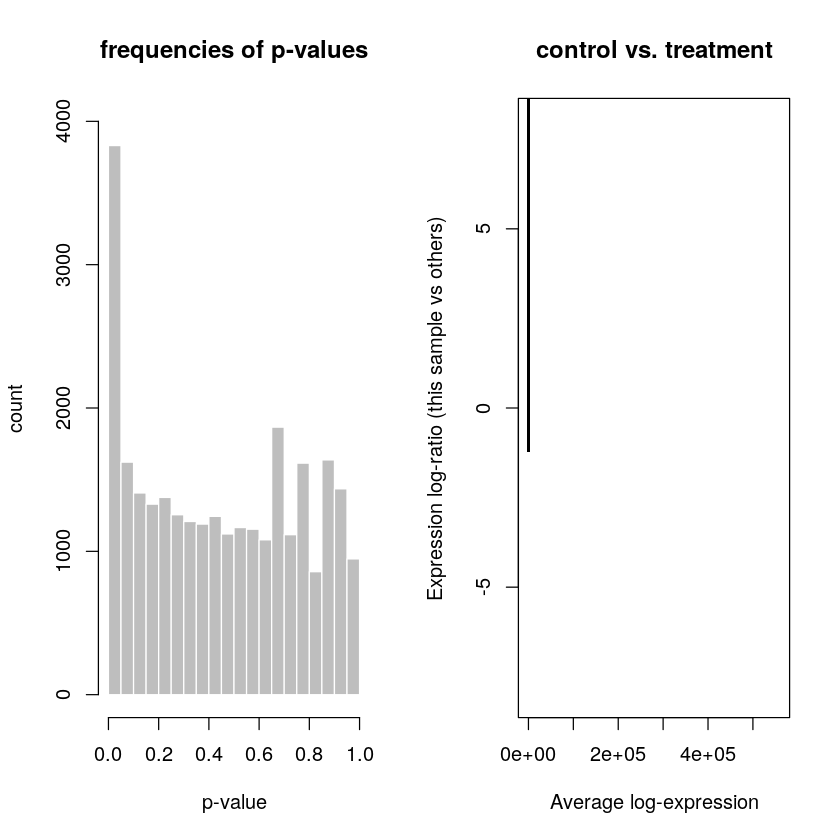

In [194]:
par(mfrow = c(1,2))
hist(DGE.results$pvalue,
    ylim = c(0,4000),
    col = "grey", border = "white", xlab = "p-value", ylab = "count",
    main = "frequencies of p-values")

plotMA(DGE.results, alpha = 0.05, main = "control vs. treatment",
    ylim = c(-8,8))


In [195]:
# sort the results according to the adjusted p - value
DGE.results.sorted <- DGE.results[order(DGE.results$padj),]
str(DGE.results.sorted)

#select genes with p-value<0.05
DGE.results.sorted <- subset(DGE.results.sorted, padj < 0.05)
str(DGE.results.sorted)

#order by fold change(absolute value)
DGE.results.sorted.byfold <- DGE.results.sorted[order(abs(DGE.results.sorted$log2FoldChange), decreasing = TRUE),]
DGE.results.sorted.byfold$log2FoldChange
#identify genes with the desired adjusted p-value cut-off

DGEgenes <- rownames(subset(DGE.results.sorted.byfold, abs(log2FoldChange) >= 1))
length(DGEgenes)

Formal class 'DESeqResults' [package "DESeq2"] with 7 slots
  ..@ priorInfo      : list()
  ..@ rownames       : chr [1:28474] "ENSMUSG00000075015" "ENSMUSG00000050272" "ENSMUSG00000009185" "ENSMUSG00000075014" ...
  ..@ nrows          : int 28474
  ..@ listData       :List of 6
  .. ..$ baseMean      : num [1:28474] 469 1398 5141 1852 137 ...
  .. ..$ log2FoldChange: num [1:28474] 3.9 -9.02 4 4.11 4.1 ...
  .. ..$ lfcSE         : num [1:28474] 0.294 0.704 0.334 0.342 0.354 ...
  .. ..$ stat          : num [1:28474] 13.3 -12.8 12 12 11.6 ...
  .. ..$ pvalue        : num [1:28474] 2.58e-40 1.29e-37 4.17e-33 3.47e-33 5.71e-31 ...
  .. ..$ padj          : num [1:28474] 5.36e-36 1.34e-33 2.16e-29 2.16e-29 2.37e-27 ...
  ..@ elementType    : chr "ANY"
  ..@ elementMetadata:Formal class 'DataFrame' [package "S4Vectors"] with 6 slots
  .. .. ..@ rownames       : NULL
  .. .. ..@ nrows          : int 6
  .. .. ..@ listData       :List of 2
  .. .. .. ..$ type       : chr [1:6] "intermediate" "

[1] -9.0179267  8.0937317 -7.6761879  7.2683618  7.1854348  6.9525384
   [7]  6.8753073  6.8619043 -6.6158333  6.3731990  6.2680328  6.0479679
  [13]  6.0461173  6.0051968  5.9526902  5.8173280 -5.7998059  5.7835466
  [19]  5.7642465  5.6976702  5.6505991 -5.6445948  5.6235092  5.4934820
  [25]  5.4523808  5.4243045 -5.3859605 -5.3801139  5.3790966  5.3628002
  [31] -5.3397424  5.3306786  5.3189256  5.2203067 -5.1886560  5.1694421
  [37]  5.0881727  5.0752055  5.0751237  5.0664293  5.0460070  5.0299410
  [43] -5.0079386  4.9890549  4.9868185  4.9601262  4.9597409  4.9376243
  [49] -4.9351350 -4.9323862  4.9280496  4.8913473  4.8772374 -4.8529322
  [55]  4.8343201  4.8192503 -4.8190566  4.8161851  4.8095086  4.8090951
  [61]  4.7929493  4.7866338  4.7840995  4.7740851 -4.7425621  4.7412979
  [67]  4.7349397  4.7230599  4.7215235 -4.7197209  4.7123195  4.7046923
  [73]  4.6826757  4.6782717  4.6662777  4.6462159  4.6410643  4.6332278
  [79]  4.6221251  4.6159982 -4.6065636  4.6034145  4.6008103  4.5954737
  [85]  4.5465485  4.5419793  4.5340239  4.5114761  4.4862350  4.4805296
  [91]  4.4645023 -4.4627332  4.4550599 -4.4542181  4.4382795  4.4359223
  [97] -4.4349772  4.4086053  4.3996939  4.3913946  4.3885310  4.3842349
 [103]  4.3817740  4.3790266  4.3736797  4.3725628  4.3715144  4.3603350
 [109]  4.3410110 -4.3408932  4.3350847  4.3335578  4.3262519  4.3229761
 [115]  4.3194029  4.3172997  4.3162803  4.2982327  4.2803645  4.2754635
 [121]  4.2701872  4.2690029  4.2645193  4.2642190  4.2604079  4.2550875
 [127]  4.2521848  4.2481021 -4.2424227  4.2142908  4.1974351  4.1948862
 [133]  4.1942865  4.1927261  4.1918785  4.1785909  4.1758576 -4.1755838
 [139]  4.1739942  4.1703209  4.1653713 -4.1589428  4.1558313  4.1495901
 [145] -4.1490796 -4.1297010  4.1287418  4.1234240  4.1218359  4.1115818
 [151]  4.1102144  4.1037639 -4.1017597  4.1006349  4.0990955  4.0847992
 [157]  4.0827315  4.0799977  4.0779521 -4.0741253  4.0727511  4.0692518
 [163]  4.0655179  4.0574220  4.0479935  4.0303701  4.0247390 -4.0233215
 [169]  4.0202445  4.0041486  4.0021474 -3.9917394  3.9881227  3.9722849
 [175]  3.9659454  3.9597481 -3.9521366  3.9495112  3.9398956  3.9303582
 [181] -3.9181233  3.9038706  3.8986699 -3.8721417  3.8608376  3.8566511
 [187]  3.8414770  3.8344792  3.8342947  3.8335394  3.8323509 -3.8289833
 [193]  3.8130270 -3.8128035 -3.8082017  3.7997359 -3.7990884  3.7929587
 [199] -3.7888337  3.7805986  3.7654611  3.7638181  3.7416038  3.7395098
 [205]  3.7203125  3.7175289  3.7044146  3.6952785 -3.6922772  3.6839504
 [211]  3.6809244 -3.6742454  3.6733379 -3.6732994  3.6626457  3.6563446
 [217]  3.6509450  3.6464329 -3.6398950  3.6297005  3.6257045 -3.6231530
 [223]  3.6143226  3.6045386 -3.6036542  3.6005475 -3.5853229  3.5833536
 [229]  3.5762923 -3.5693593  3.5655715  3.5408945 -3.5376454  3.5323152
 [235]  3.5204471 -3.5173575  3.5127363 -3.5113440  3.4836954 -3.4803712
 [241]  3.4781549  3.4717323  3.4675933  3.4650525  3.4622453  3.4603673
 [247]  3.4572123 -3.4512466 -3.4466304  3.4461291 -3.4283732  3.4223686
 [253]  3.4192612  3.4067154  3.4042968  3.4029534  3.4029111  3.4016754
 [259]  3.3986157 -3.3980651 -3.3949945 -3.3869251  3.3831579  3.3642122
 [265]  3.3634317  3.3624754  3.3614442  3.3574521  3.3532236  3.3521969
 [271]  3.3458897  3.3401268  3.3398732 -3.3393205  3.3350319  3.3309205
 [277]  3.3225415 -3.3159281  3.3145911  3.3056088  3.3053567  3.3031294
 [283]  3.2905902  3.2879987  3.2870913  3.2795128  3.2780212  3.2748679
 [289]  3.2713419  3.2687486  3.2661809  3.2645591  3.2645017  3.2627949
 [295]  3.2620533  3.2600765  3.2492858  3.2448765  3.2426643  3.2351715
 [301] -3.2350574  3.2199652  3.2178739  3.2156192  3.2154701  3.2097495
 [307] -3.2065673 -3.2049355  3.2046984  3.2037658  3.1974749 -3.1963040
 [313]  3.1895438 -3.1863262  3.1862652 -3.1765008 -3.1699060 -3.1542995
 [319] -3.1494307  3.1452348 -3.1430305  3.1394627 -3.1359880  3.1357763
 [325]  3.1327495  3.1321156  3.1253128  3.1193739 -3.1174306

[1] 1251

,ctl1,ctl2,ctl3,ctl4,treat1,treat2,treat3,treat4
ENSMUSG00000050272,11.291993,10.288533,12.184175,11.424566,2.383007,3.850636,2.610821,0.7990993
ENSMUSG00000085786,0.000000,0.000000,0.000000,0.000000,7.406410,2.556384,4.553203,5.6883945
ENSMUSG00000034009,8.168659,7.688011,10.981603,9.519275,2.057336,2.828407,2.833945,1.3103569
ENSMUSG00000047222,0.000000,0.000000,0.000000,0.000000,5.203120,6.624193,2.346761,1.7935691
ENSMUSG00000040026,6.899827,8.001150,6.055589,6.987936,14.968351,13.968345,11.373037,14.9425200
ENSMUSG00000027869,0.000000,0.000000,0.000000,0.000000,1.636039,6.010558,2.833945,5.3561712
ENSMUSG00000092009,0.000000,1.211315,0.000000,0.000000,1.038476,6.659460,3.197491,6.0143830
ENSMUSG00000000120,13.081942,11.546460,13.270481,12.791669,6.183404,4.799747,7.361701,4.9924936
ENSMUSG00000030757,0.000000,0.000000,0.000000,0.000000,5.466507,4.521705,3.349835,1.1592141
ENSMUSG00000030077,1.111646,1.860355,0.000000,1.137092,6.534543,4.359610,6.838056,7.2684998


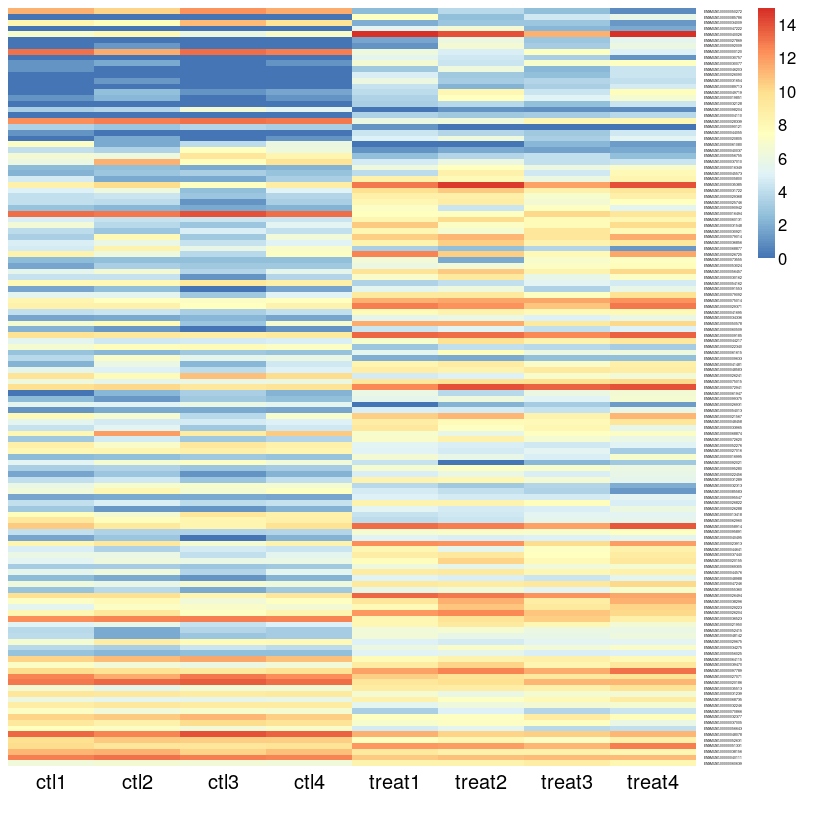

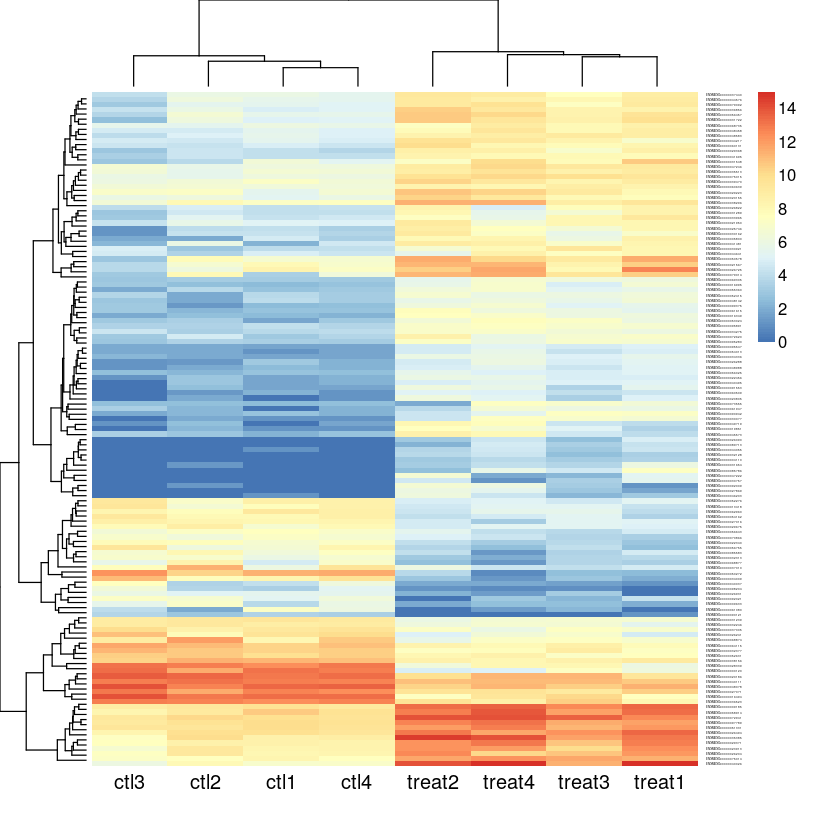

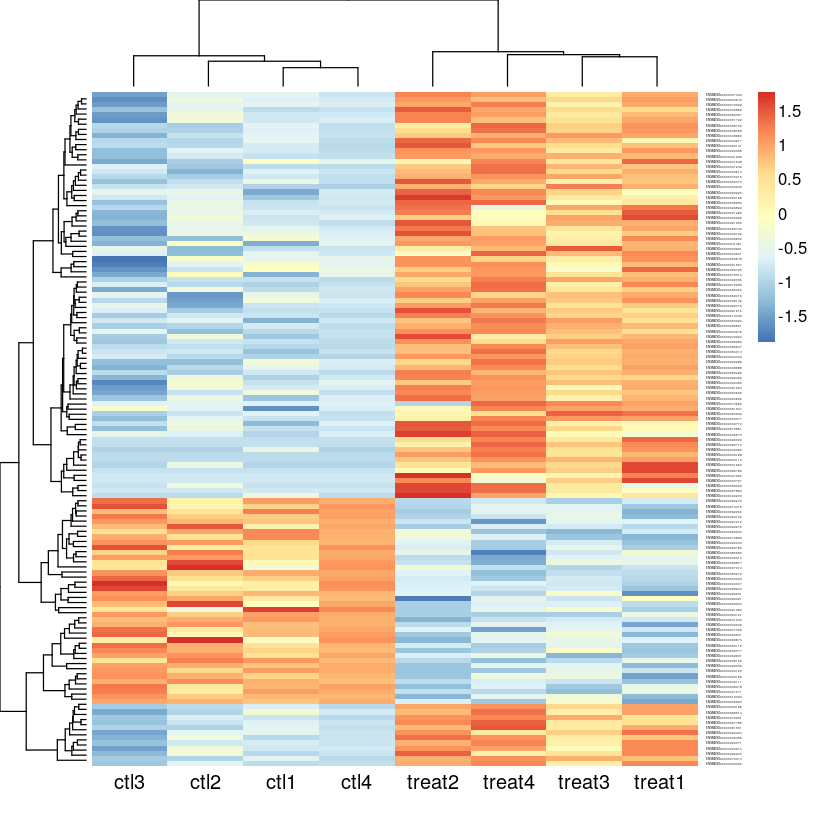

In [152]:

 # aheatmap needs a matrix of values,e.g., a matrix of DE genes with the transformed read counts for each replicate


#extract the normalized read counts for DE genes into a matrix
hm.mat_DGEgenes <- log.norm.counts[DGEgenes,]
hm.mat_DGEgenes 
# plot the normalized read counts of DE genes sorted by the adjusted p - value
aheatmap(hm.mat_DGEgenes, Rowv = NA, Colv = NA)

# combine the heatmap with hierarchical clustering
aheatmap(hm.mat_DGEgenes,
    Rowv = TRUE , Colv = TRUE , # add dendrograms to rows and columns
    distfun = "euclidean" , hclustfun = "average" )
 
# scale the read counts per gene to emphasize the sample - type - specific differences
aheatmap (hm.mat_DGEgenes,
    Rowv = TRUE, Colv = TRUE,
    distfun = "euclidean", hclustfun = "average",
    scale = "row") # values are transformed into distances from the centerof the row - specific average : ( actual value - mean of the group ) /standard deviation 


In [190]:

# list the types of keywords that are available to query the annotation database
keytypes(EnsDb.Mmusculus.v75)

 # list columns that can be retrieved from the annotation data base
columns(EnsDb.Mmusculus.v75)

 # make a batch retrieval for all DE genes
anno.DESeq <- select( EnsDb.Mmusculus.v75,
    keys = DGEgenes, keytype = "GENEID" , # to retrieve all genes
    columns = c("GENEID" , "SEQNAME","GENESEQSTART", "GENESEQEND", "SEQSTRAND", "GENENAME"))
str(anno)

 #check whether SNF2 pops up among the top downregulated genes
#DGE . results . sorted _ logFC <- DGE . results [ order ( DGE . results $ log2FoldChange ) , ]
 #DGEgenes _ logFC <- rownames ( subset ( DGE . results . sorted _ logFC , padj < 0.05) )
 #head ( anno [ match ( DGEgenes _ logFC , anno $ ORF ) , ])
 
# find the ORF corresponding to SNF2
#subset ( anno , GENENAME == " SNF2 " )
 
# DESeq2 offers a wrapper function to plot read counts for single genes
#library ( grDevices ) # for italicizing the gene name
#plotCounts ( dds = DESeq . ds ,
 #gene = " YOR290C " ,
 #normalized = TRUE , transform = FALSE ,
 #main = expression ( atop ( " Expression of " * italic ( " snf2 " ) , " ( YOR290C ) ")) )
 

[1] "ENTREZID"            "EXONID"              "GENEBIOTYPE"        
 [4] "GENEID"              "GENENAME"            "PROTDOMID"          
 [7] "PROTEINDOMAINID"     "PROTEINDOMAINSOURCE" "PROTEINID"          
[10] "SEQNAME"             "SEQSTRAND"           "SYMBOL"             
[13] "TXBIOTYPE"           "TXID"                "TXNAME"             
[16] "UNIPROTID"

[1] "ENTREZID"            "EXONID"              "EXONIDX"            
 [4] "EXONSEQEND"          "EXONSEQSTART"        "GENEBIOTYPE"        
 [7] "GENEID"              "GENENAME"            "GENESEQEND"         
[10] "GENESEQSTART"        "INTERPROACCESSION"   "ISCIRCULAR"         
[13] "PROTDOMEND"          "PROTDOMSTART"        "PROTEINDOMAINID"    
[16] "PROTEINDOMAINSOURCE" "PROTEINID"           "PROTEINSEQUENCE"    
[19] "SEQCOORDSYSTEM"      "SEQLENGTH"           "SEQNAME"            
[22] "SEQSTRAND"           "SYMBOL"              "TXBIOTYPE"          
[25] "TXCDSSEQEND"         "TXCDSSEQSTART"       "TXID"               
[28] "TXNAME"              "TXSEQEND"            "TXSEQSTART"         
[31] "UNIPROTDB"           "UNIPROTID"           "UNIPROTMAPPINGTYPE"

'data.frame':	130 obs. of  6 variables:
 $ GENEID      : chr  "ENSMUSG00000050272" "ENSMUSG00000085786" "ENSMUSG00000034009" "ENSMUSG00000047222" ...
 $ SEQNAME     : chr  "16" "6" "3" "14" ...
 $ GENESEQSTART: int  96592079 128951204 79641611 51255266 46711998 98805504 49057486 95568818 123479516 103510876 ...
 $ GENESEQEND  : int  97170752 128975029 79737880 51256112 46715676 98814443 49199104 95587735 123500449 103733035 ...
 $ SEQSTRAND   : int  -1 -1 -1 -1 -1 -1 1 -1 -1 1 ...
 $ GENENAME    : chr  "Dscam" "Gm15987" "Rxfp1" "Ear11" ...


## edgeR

In [157]:
BiocManager::install("edgeR")
library(edgeR)
 


Bioconductor version 3.9 (BiocManager 1.30.9), R 3.6.1 (2019-07-05)
Installing package(s) 'edgeR'
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'askpass', 'backports', 'boot', 'callr', 'caret', 'clipr',
  'cluster', 'curl', 'data.table', 'dbplyr', 'digest', 'dplyr', 'evaluate',
  'foreach', 'foreign', 'formatR', 'fs', 'ggplot2', 'glmnet', 'gower', 'haven',
  'hexbin', 'hms', 'htmltools', 'htmlwidgets', 'httpuv', 'httr', 'ipred',
  'IRkernel', 'iterators', 'KernSmooth', 'knitr', 'later', 'lava', 'markdown',
  'MASS', 'mgcv', 'mime', 'modelr', 'nlme', 'numDeriv', 'openssl', 'pillar',
  'pkgconfig', 'processx', 'progress', 'promises', 'purrr', 'quantmod', 'Rcpp',
  'recipes', 'repr', 'reprex', 'rmarkdown', 'rvest', 'shiny', 'sys', 'tibble',
  'tidyr', 'tinytex', 'TTR', 'whisker', 'xfun', 'xml2'
Loading required package: limma

Attaching package: 'limma'

The following object is masked from 'package:DESeq2':

    plotMA

The following object is

In [159]:
sample_info.edger <- factor(c(rep("ctl", 4) , rep("treat" , 4)))
sample_info.edger <- relevel(sample_info.edger, ref = "ctl" )
edgeR.DGElist <- DGEList(counts = readcounts, group = sample_info.edger)
head(edgeR.DGElist$counts)
edgeR.DGElist$samples


,ctl1,ctl2,ctl3,ctl4,treat1,treat2,treat3,treat4
ENSMUSG00000102693,0,0,0,0,0,0,0,0
ENSMUSG00000064842,0,0,0,0,1,0,0,0
ENSMUSG00000051951,2,0,1,1,11,2,1,24
ENSMUSG00000102851,0,0,0,0,0,0,0,0
ENSMUSG00000103377,0,0,0,0,0,0,0,0
ENSMUSG00000104017,0,0,0,0,0,0,0,0


,group,lib.size,norm.factors
ctl1,ctl,41375067,1
ctl2,ctl,34613772,1
ctl3,ctl,35482626,1
ctl4,ctl,37119570,1
treat1,treat,40026818,1
treat2,treat,36909672,1
treat3,treat,40303811,1
treat4,treat,173631720,1


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   -Inf    -Inf  -2.818    -Inf   4.105  17.622 

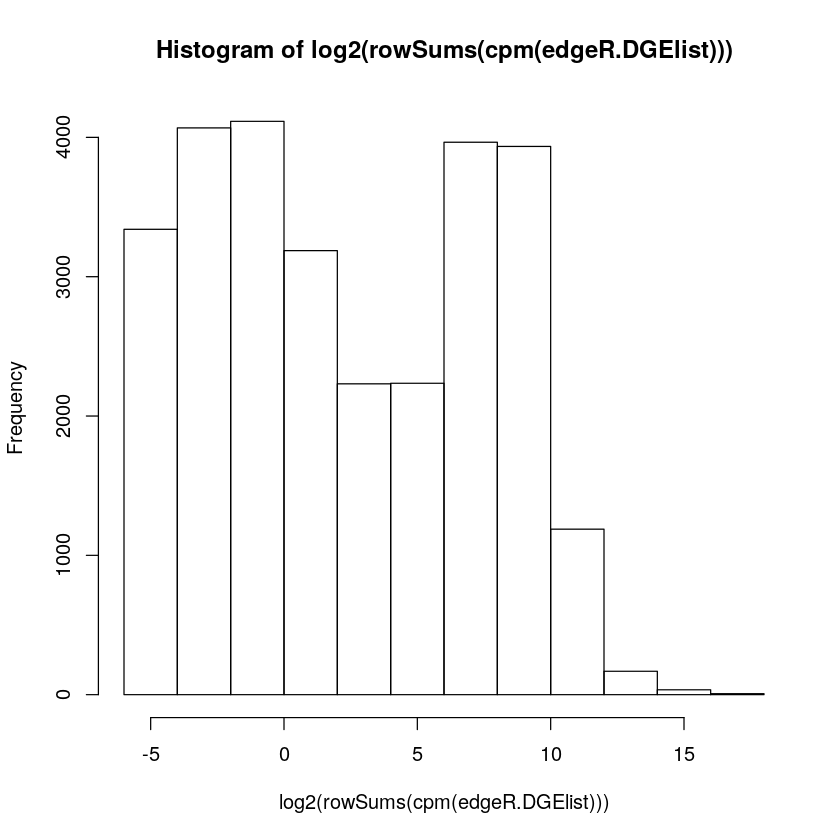

In [161]:
#edgeR also recommends removing genes with almost no coverage. In order to determine a sensible cutoff, we
#plot a histogram of counts per million calculated by edgeR’s cpm() function.

#get an impression of the coverage across samples
hist(log2(rowSums(cpm(edgeR.DGElist))))
summary(log2(rowSums(cpm(edgeR.DGElist))))


In [169]:
 #remove genes that do not have one count per million in at least 5 samples ( adjust this to your sample ! )

 keep <- rowSums( cpm ( edgeR.DGElist ) >= 1) >= 4
 edgeR.DGElist <- edgeR.DGElist[keep ,]

Formal class 'DGEList' [package "edgeR"] with 1 slot
  ..@ .Data:List of 2
  .. ..$ : int [1:12171, 1:8] 1159 842 938 39 2273 4566 99 125 3969 161 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:12171] "ENSMUSG00000033845" "ENSMUSG00000025903" "ENSMUSG00000033813" "ENSMUSG00000002459" ...
  .. .. .. ..$ : chr [1:8] "ctl1" "ctl2" "ctl3" "ctl4" ...
  .. ..$ :'data.frame':	8 obs. of  3 variables:
  .. .. ..$ group       : Factor w/ 2 levels "ctl","treat": 1 1 1 1 2 2 2 2
  .. .. ..$ lib.size    : num [1:8] 41375067 34613772 35482626 37119570 40026818 ...
  .. .. ..$ norm.factors: num [1:8] 1 1 1 1 1 1 1 1


In [170]:
# recompute library sizes after filtering
edgeR.DGElist$samples$lib.size <- colSums(edgeR.DGElist$counts)
head(edgeR.DGElist$samples)

 

,group,lib.size,norm.factors
ctl1,ctl,41300574,1
ctl2,ctl,34513978,1
ctl3,ctl,35393591,1
ctl4,ctl,37032286,1
treat1,treat,39900647,1
treat2,treat,36799913,1


In [171]:
#Calculate normalization factors for the library sizes. We use the standard edgeR method here, which is
#the trimmed mean of M-values; if you wanted to use, for example, DESeq’s size factor, you could use
#method = "RLE"). See Table 13 for details of the methods.
edgeR.DGElist <- calcNormFactors(edgeR.DGElist, method = "TMM")
edgeR.DGElist$samples
 


,group,lib.size,norm.factors
ctl1,ctl,41300574,0.9725258
ctl2,ctl,34513978,0.9702353
ctl3,ctl,35393591,1.0173826
ctl4,ctl,37032286,0.9985048
treat1,treat,39900647,1.0159398
treat2,treat,36799913,1.0006630
treat3,treat,40191668,1.0647705
treat4,treat,173123205,0.9637746


In [174]:
 #specify the design setup - the design matrix looks a bit intimitating , but if
 #you just focus on the formula [ ~ sample _ info . edger ] you can see that it ' s
 #exactly what we used for DESeq2 , too

design <- model.matrix(~sample_info.edger)
 # estimate the dispersion for all read counts across all samples
edgeR.DGElist <- estimateDisp(edgeR.DGElist, design)
 # fit the negative binomial model
edger_fit <- glmFit(edgeR.DGElist, design )
 # perform the testing for every gene using the neg . binomial model
edger_lrt <- glmLRT(edger_fit)
 

In [175]:
 # perform the testing for every gene using the neg . binomial model
edger_lrt <- glmLRT(edger_fit)
 

In [189]:
 # extract results from edger _ lrt $ table plus adjusted p - values
DGE.results_edgeR <- topTags(edger_lrt, n = Inf , # to retrieve all genes
    sort.by = "logFC", p.value = 0.05, adjust.method = "BH")
DGE.results_edgeR$table


DGEgenes.edgeR <- rownames(subset(DGE.results_edgeR$table, abs(logFC) >= 1))
str(DGE.results_edgeR$table[DGEgenes.edgeR,])



,logFC,logCPM,LR,PValue,FDR
ENSMUSG00000040026,7.255407,7.926059,65.74432,5.133840e-16,8.926281e-13
ENSMUSG00000000120,-6.557112,6.327711,76.08633,2.715305e-18,6.609595e-15
ENSMUSG00000028339,-5.318418,6.386106,71.18576,3.251260e-17,6.595182e-14
ENSMUSG00000037010,-4.797267,3.358638,20.30524,6.601958e-06,8.640046e-04
ENSMUSG00000035385,4.688622,7.258888,37.17518,1.079795e-09,5.054687e-07
ENSMUSG00000031722,4.677094,3.371785,37.95090,7.254765e-10,3.956617e-07
ENSMUSG00000031548,4.493741,3.201493,19.68720,9.121047e-06,1.099131e-03
ENSMUSG00000026725,4.426701,5.095425,16.57710,4.671171e-05,3.384096e-03
ENSMUSG00000079014,4.414293,4.438283,17.00060,3.736804e-05,2.860418e-03
ENSMUSG00000036856,4.393784,3.041734,46.66569,8.419041e-12,9.315286e-09


'data.frame':	510 obs. of  5 variables:
 $ logFC : num  7.26 -6.56 -5.32 -4.8 4.69 ...
 $ logCPM: num  7.93 6.33 6.39 3.36 7.26 ...
 $ LR    : num  65.7 76.1 71.2 20.3 37.2 ...
 $ PValue: num  5.13e-16 2.72e-18 3.25e-17 6.60e-06 1.08e-09 ...
 $ FDR   : num  8.93e-13 6.61e-15 6.60e-14 8.64e-04 5.05e-07 ...


In [196]:
library ( limma )
 # limma also needs a design matrix , just like edgeR
 #transform the count data to log2 - counts - per - million and estimate
 #the mean - variance relationship , which is used to compute weights
 #for each count -- this is supposed to make the read counts
 #amenable to be used with linear models

 design <- model.matrix(~sample_info.edger)
 rownames(design) <- colnames(edgeR.DGElist)
 voomTransformed <- voom (edgeR.DGElist, design, plot = FALSE)

In [197]:
# fit a linear model for each gene
voomed.fitted <- lmFit(voomTransformed, design = design)
 # compute moderated t - statistics , moderated F - statistics ,
 # and log - odds of differential expression
voomed.fitted <- eBayes(voomed.fitted)

In [209]:
 # extract gene list with logFC and statistical measures
colnames(design) # check how the coefficient is named
DGE.results_limma <- topTable(voomed.fitted, coef = "sample_info.edgertreat" ,
 number = Inf, adjust.method = "BH", sort.by = "logFC" )

DGE.results_limma <- subset(DGE.results_limma, abs(logFC)>=1)
str(DGE.results_limma)

[1] "(Intercept)"            "sample_info.edgertreat"

'data.frame':	2051 obs. of  6 variables:
 $ logFC    : num  -6.88 6.87 5.58 -5.48 5.2 ...
 $ AveExpr  : num  3.79 4.94 2.41 4.51 2.93 ...
 $ t        : num  -11.11 7.08 5.53 -10.88 5.32 ...
 $ P.Value  : num  2.10e-06 7.20e-05 4.23e-04 2.50e-06 5.57e-04 ...
 $ adj.P.Val: num  0.00609 0.03622 0.07293 0.00609 0.0788 ...
 $ B        : num  4.816 2.053 0.425 4.89 0.191 ...


In [ ]:
# make a Venn diagram
BiocManager::install("gplots")
library(gplots)



In [217]:
BiocManager::install("UpSetR")
library(UpSetR)

Bioconductor version 3.9 (BiocManager 1.30.9), R 3.6.1 (2019-07-05)
Installing package(s) 'UpSetR'
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'askpass', 'backports', 'boot', 'callr', 'caret', 'clipr',
  'cluster', 'curl', 'data.table', 'dbplyr', 'digest', 'dplyr', 'evaluate',
  'foreach', 'foreign', 'formatR', 'fs', 'ggplot2', 'glmnet', 'gower', 'haven',
  'hexbin', 'hms', 'htmltools', 'htmlwidgets', 'httpuv', 'httr', 'ipred',
  'IRkernel', 'iterators', 'KernSmooth', 'knitr', 'later', 'lava', 'markdown',
  'MASS', 'mgcv', 'mime', 'modelr', 'nlme', 'numDeriv', 'openssl', 'pillar',
  'pkgconfig', 'processx', 'progress', 'promises', 'purrr', 'quantmod', 'Rcpp',
  'recipes', 'repr', 'reprex', 'rmarkdown', 'rvest', 'shiny', 'sys', 'tibble',
  'tidyr', 'tinytex', 'TTR', 'whisker', 'xfun', 'xml2'


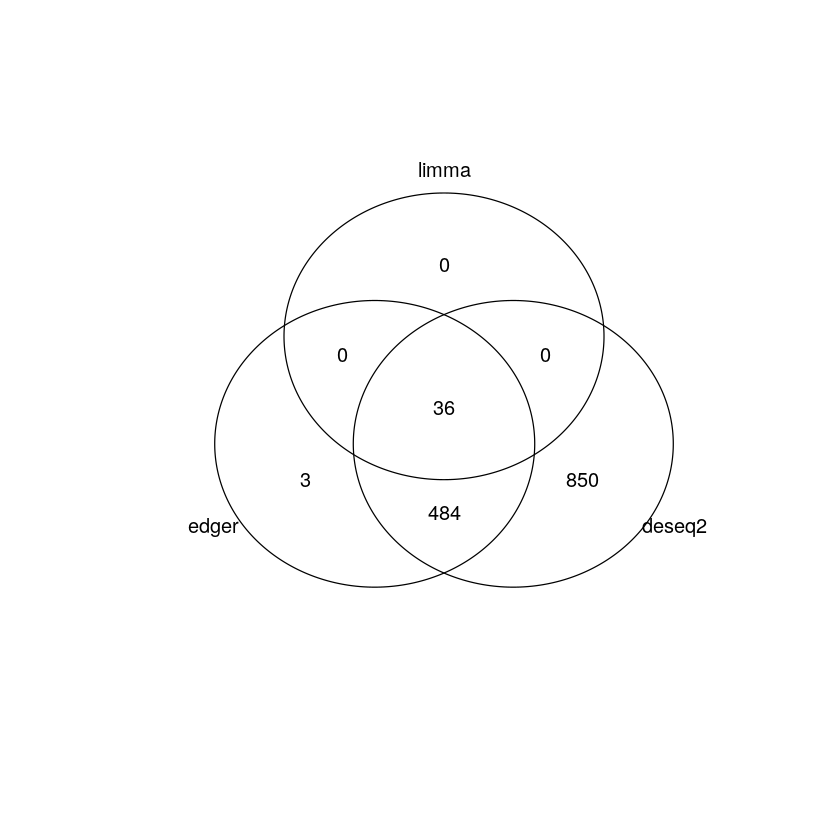

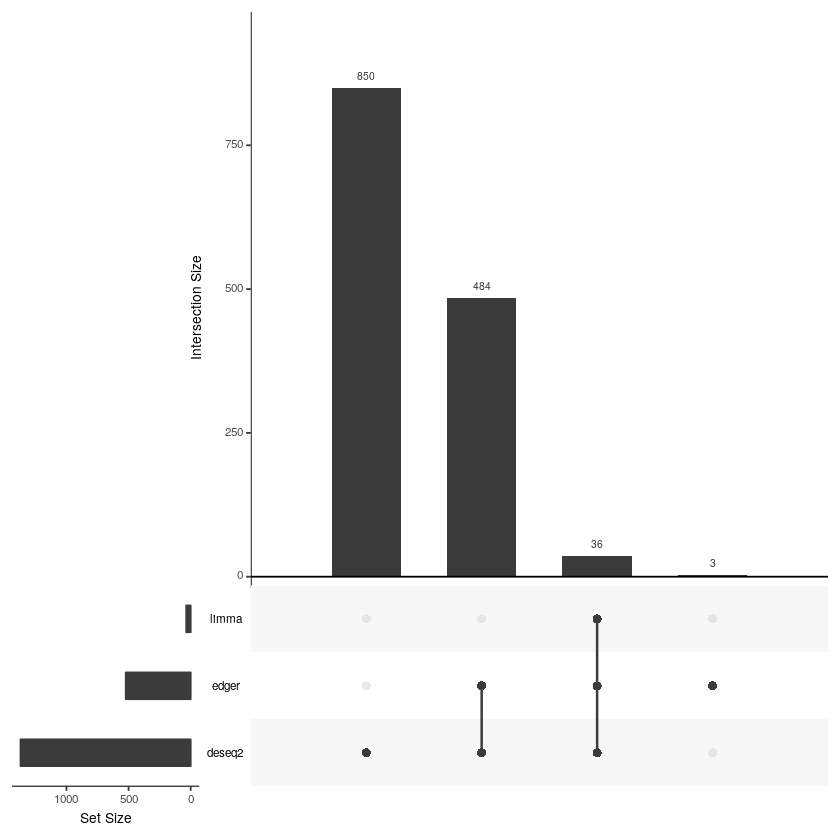

In [218]:
DE_list <- list(edger = rownames(subset(DGE.results_edgeR$table, FDR <=0.05)),
     deseq2 = rownames(subset(DGE.results, padj <=0.05)),
     limma = rownames (subset(DGE.results_limma,adj.P.Val <=0.05)))
gplots::venn(DE_list)


 DE_gns <- UpSetR::fromList(DE_list)
 UpSetR::upset(DE_gns,order.by = "freq")


In [223]:
#correlation of logFC for genes found DE in all three tools
 DE_gns_all <- rownames(DE_gns[rowSums(DE_gns) == 3 ,]) # extract the names
DE_gns_all

[1] "1"   "2"   "3"   "6"   "10"  "11"  "14"  "16"  "18"  "22"  "23"  "36" 
[13] "42"  "43"  "46"  "53"  "71"  "73"  "74"  "81"  "91"  "93"  "94"  "110"
[25] "125" "133" "153" "177" "183" "186" "199" "209" "211" "232" "349" "367"

In [225]:
 #make a data . frame of fold change values
 DE_fc <- data.frame( edger = DGE.results_edgeR[DE_gns_all, ]$table$logFC ,
         limma = DGE.results_limma[DE_gns_all,]$logFC,
         deseq2 = DGE.results[DE_gns_all,]$log2FoldChange ,
         row.names = DE_gns_all)
DE_fc

,edger,limma,deseq2
1,NA,NA,NA
2,NA,NA,NA
3,NA,NA,NA
6,NA,NA,NA
10,NA,NA,NA
11,NA,NA,NA
14,NA,NA,NA
16,NA,NA,NA
18,NA,NA,NA
22,NA,NA,NA
